# Support Vector Machines with String Kernels

An example of how to build SVM models with our string kernels by just adding 2 lines of code to a standard SVM pipeline for ancestry classification.

The computation that is used is described in detail in [our paper](https://www.biorxiv.org/content/10.1101/2021.09.19.460980v1) and if you end up using this in your research we kindly ask you to cite us! :)

<img align="left" caption="String Kernel Computations" src="doc/fig/triangular_numbers.png" width="800" height="400">

Let's start by loading the data. The data is made up but based on patterns from real human samples.


In [2]:
import numpy as np
samples_train = np.load("data/samples_train.npy")
samples_validation = np.load("data/samples_validation.npy")
ancestry_train = np.load("data/ancestry_train.npy")
ancestry_validation = np.load("data/ancestry_validation.npy")
reference = np.load("data/reference.npy")
populations = np.load("data/populations.npy")

print("number of training samples:", len(samples_train))
print("number of validation samples:", len(samples_validation))
print("Sequence length:", len(reference))
print("Number of ancestries:", len(populations))

The sequences look like this, where the columns is a specific SNP position and columns are samples.

In [4]:
samples_train

array([['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'A', 'A', ..., 'T', 'G', 'G'],
       ...,
       ['T', 'A', 'A', ..., 'T', 'C', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G']], dtype='<U1')

We can turn them into binary format by matching it with the reference file s.t. 0s mean you match the reference, 1s means you don't.

In [5]:
X_train = (samples_train != reference).astype(int)
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

Our ancestry labels are currently in letter format

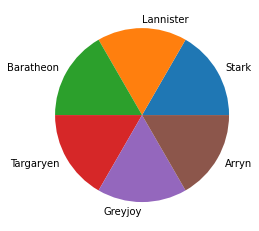

array(['Arryn', 'Baratheon', 'Greyjoy', 'Lannister', 'Stark', 'Targaryen'],
      dtype='<U9')

In [6]:
from src.utils import plot_label_distribution

plot_label_distribution(ancestry_train)
np.unique(ancestry_train)

But we can change that. Here we encode each ancestry by a number on the interval [0,number_of_ancestries]

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ancestry_train)
y_train = le.transform(ancestry_train)
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

And let's repeat the steps above with the validation data

In [8]:
X_val = (samples_validation != reference).astype(int)
y_val = le.transform(ancestry_validation)

Now, let's train a **vanilla Support Vector Machine classifier** from the sklearn library to learn to map these sequences to the corresponding ancestries.

In [9]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_accuracy*100, 2)))

Validation Accuracy: 59.17%


Huh! we got a decent accuracy but can we do better?
Using the **String Kernel** from [Lodhi et al.](https://www.jmlr.org/papers/volume2/lodhi02a/lodhi02a.pdf) using the computations listed in [our paper](https://www.biorxiv.org/content/10.1101/2021.09.19.460980v1) we get quite the improvement by basically the same code:

In [10]:
from src.kernels import string_kernel

svm_sk_model = svm.SVC(kernel=string_kernel)
svm_sk_model.fit(X_train, y_train)
y_pred = svm_sk_model.predict(X_val)
svm_sk_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_sk_accuracy*100, 2)))

Validation Accuracy: 69.17%


As we describe in our paper, there is no law that says Lodhi's string kernel is optimal. Our generalization, the **Polynomial String Kernel**, can squeeze out a few extra percentages as we see here below.

In [11]:
from src.kernels import polynomial_string_kernel

svm_psk_model = svm.SVC(kernel=polynomial_string_kernel)
svm_psk_model.fit(X_train, y_train)
y_pred = svm_psk_model.predict(X_val)
svm_psk_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_psk_accuracy*100, 2)))

Validation Accuracy: 71.67%


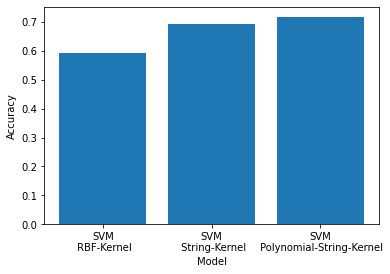

In [14]:
from src.utils import plot_accuracies

plot_accuracies({
    "SVM\n RBF-Kernel": svm_accuracy,
    "SVM\n String-Kernel": svm_sk_accuracy,
    "SVM\n Polynomial-String-Kernel": svm_psk_accuracy
})